In [40]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.read_csv("../1_Enrich_Data/tracking_osm_convexhull.csv")  

osm_features = [
    "street_length_total", "intersection_count", "street_density_km",
    "edge_density_km", "circuity_avg", "intersection_density_km", "node_density_km"
]
gps_features = [
    "num_points", "bbox_area", "point_density",
    "avg_segment_distance", "num_stops"
]
X_osm = df[osm_features].fillna(0)
X_scaled = StandardScaler().fit_transform(X_osm)


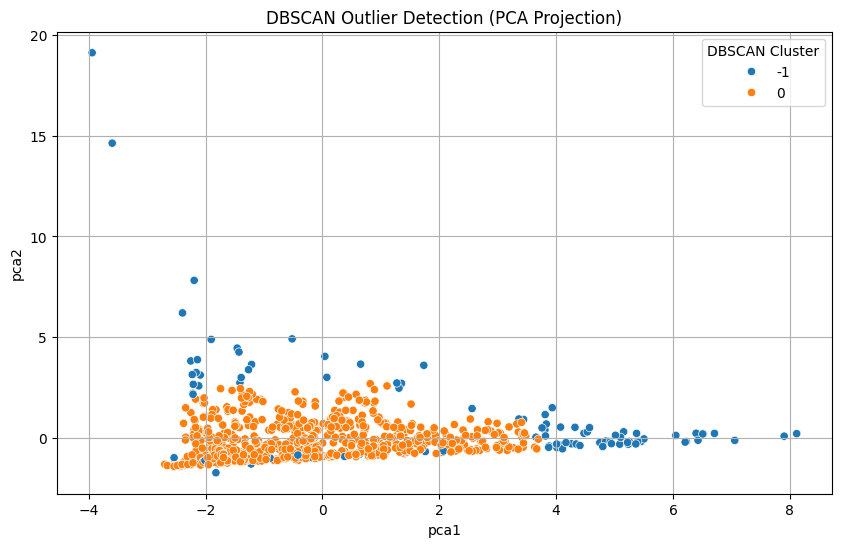

In [41]:

db = DBSCAN(eps=1, min_samples=40)
df["cluster"] = db.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df["pca1"] = X_pca[:, 0]
df["pca2"] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="pca1", y="pca2", hue="cluster", palette="tab10")
plt.title("DBSCAN Outlier Detection (PCA Projection)")
plt.grid(True)
plt.legend(title="DBSCAN Cluster")
plt.show()


In [42]:
df_clean = df[df["cluster"] != -1].copy()
print(f"Removed {len(df) - len(df_clean)} outliers using DBSCAN")

Removed 103 outliers using DBSCAN


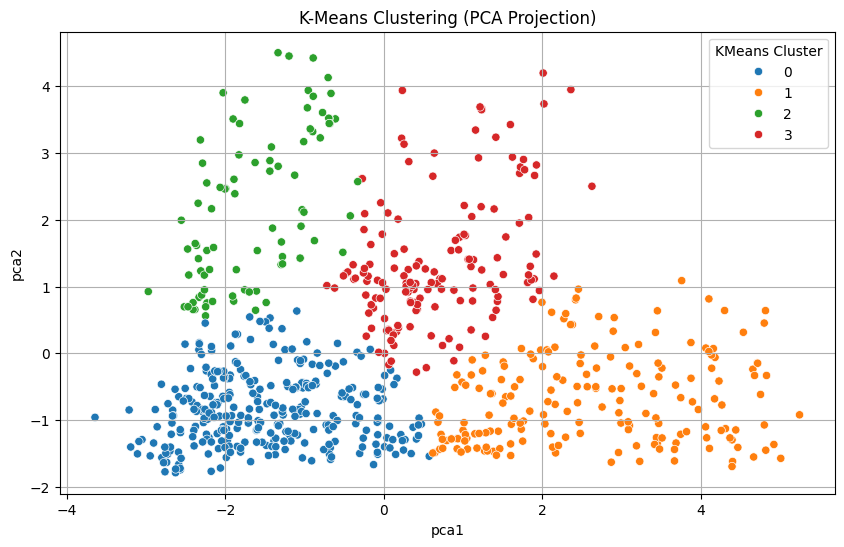

In [43]:
X_clean = df_clean[osm_features]
X_clean_scaled = StandardScaler().fit_transform(X_clean)

kmeans = KMeans(n_clusters=4, random_state=42)
df_clean["cluster"] = kmeans.fit_predict(X_clean_scaled)

X_pca = PCA(n_components=2).fit_transform(X_clean_scaled)
df_clean["pca1"] = X_pca[:, 0]
df_clean["pca2"] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x="pca1", y="pca2", hue="cluster", palette="tab10")
plt.title("K-Means Clustering (PCA Projection)")
plt.grid(True)
plt.legend(title="KMeans Cluster")
plt.show()

df_clean.to_csv("osm_clustered_cleaned.csv", index=False)

In [44]:
# Summarize feature means by cluster
summary = df_clean.groupby("cluster").mean(numeric_only=True)
summary["count"] = df_clean["cluster"].value_counts().sort_index()
summary


tracking_id  num_points  bbox_area  point_density  \
cluster                                                       
0        43201.811502  145.872204   0.003829  139633.618533   
1        56179.751295  130.772021   0.001205  280202.362209   
2        34365.593023  178.558140   0.020038   10324.814327   
3        53604.141935  173.509677   0.005793   35781.900069   

         avg_segment_distance   num_stops  street_length_total  \
cluster                                                          
0                  143.153655  145.872204         24395.122507   
1                   79.893970  130.772021         29973.145762   
2                  175.620487  178.558140        154151.521203   
3                  117.187341  173.509677        102625.616685   

         intersection_count  street_density_km  edge_density_km  circuity_avg  \
cluster                                                                         
0                 90.456869        2674.666877      5125.488709      1.074796   
1                157.461140        7462.303509     14026.679864      1.060352   
2                496.372093        2640.681265      5114.772998      1.088048   
3                502.303226        5187.181940      9858.734908      1.064686   

         intersection_density_km  node_density_km      pca1      pca2  count  
cluster                                                                       
0                      11.375828        14.085313 -1.480078 -0.847472    313  
1                      41.606812        52.709730  2.586166 -0.696558    193  
2                       8.779977        11.399240 -1.632398  2.165963     86  
3                      25.554461        32.941837  0.674326  1.376913    155

In [45]:
N = 200
example_ids = df_clean.groupby("cluster")["tracking_id"].apply(lambda x: x.sample(min(N, len(x)), random_state=42)).explode().tolist()

waypoints = pd.read_parquet("../data/filtered_waypoints.parquet")

example_routes = waypoints[waypoints["id_tracking"].isin(example_ids)].copy()


In [46]:
import folium
from folium import Map, PolyLine, Marker
from IPython.display import display

cluster_colors = ["blue", "orange", "green", "red"]

first_route = example_routes[example_routes["id_tracking"] == example_ids[0]].sort_values("sequence")
center = [first_route.iloc[0]["latitude"], first_route.iloc[0]["longitude"]]

m = folium.Map(location=center, zoom_start=12)

for tracking_id in example_ids:
    route = example_routes[example_routes["id_tracking"] == tracking_id].sort_values(by="sequence")
    coords = list(zip(route["latitude"], route["longitude"]))
    cluster_label = df_clean[df_clean["tracking_id"] == tracking_id]["cluster"].values[0]

    folium.PolyLine(coords, color=cluster_colors[cluster_label], weight=4, tooltip=f"Cluster {cluster_label}").add_to(m)
    Marker(coords[0], tooltip=f"Tracking {tracking_id}").add_to(m)

display(m)